In [1]:
import os

os.chdir('C:/Users/EunJin/Desktop/dacon/뱅크샐러드/train')
os.getcwd()

'C:\\Users\\EunJin\\Desktop\\dacon\\뱅크샐러드\\train'

In [2]:
import pandas as pd
pd.set_option('display.max_columns', 500)

train = pd.read_csv('train.csv')
train.head(10)

,store_id,date,time,card_id,amount,installments,days_of_week,holyday
0,0,2016-12-14,18:05:31,d297bba73f,5,NaN,2,0
1,0,2016-12-14,18:05:54,d297bba73f,-5,NaN,2,0
2,0,2016-12-19,12:42:31,0880849c05,144,NaN,0,0
3,0,2016-12-19,12:48:08,8b4f9e0e95,66,NaN,0,0
4,0,2016-12-19,13:31:08,7ad237eed0,24,NaN,0,0
5,0,2016-12-19,13:36:39,30b1422f77,44,NaN,0,0
6,0,2016-12-19,14:00:23,6dd8dad5ab,146,NaN,0,0
7,0,2016-12-19,14:01:36,a4a425c5d2,6,NaN,0,0
8,0,2016-12-19,14:09:46,f213c011fe,306,NaN,0,0
9,0,2016-12-19,14:13:02,a185b7b11f,51,NaN,0,0


In [3]:
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns    
from tqdm import tqdm
import gc
import random
import lightgbm as lgb
import re
from sklearn.metrics import *
from sklearn.model_selection import KFold
import warnings
warnings.filterwarnings(action='ignore')

In [4]:
train = train.fillna(0)

In [5]:
train['timestamp'] = train.date+' '+train.time
train['timestamp'] = pd.to_datetime(train['timestamp'], format='%Y-%m-%d %H:%M:%S')

train['year'] = train['date'].apply(lambda x: int(x[:4]))
train['month'] = train['date'].apply(lambda x: int(x[5:7]))
train['day'] = train['date'].apply(lambda x: int(x[8:10]))

# hour/min/sec 변수 만들기

train['hour'] = train['time'].apply(lambda x: int(x[:2]))
train['min'] = train['time'].apply(lambda x: int(x[3:5]))
train['sec'] = train['time'].apply(lambda x: int(x[6:8]))

In [6]:
def seasonal(month) :
    if (month <= 5) & (month >= 3):
        return 0
    elif (month >= 6) & (month <= 8):
        return 1
    elif (month >= 9) & (month <= 11):
        return 2
    else :
        return 3
train['season'] = train['month'].apply(lambda x : seasonal(x))

In [7]:
def timezone(month) :
    if (month <= 5) & (month >= 1):
        return 0
    elif (month >= 6) & (month <= 10):
        return 1
    elif (month >= 11) & (month <= 14):
        return 2
    elif (month >= 15) & (month <= 17):
        return 3
    elif (month >= 18) & (month <= 20):
        return 4
    else :
        return 5
train['timezone'] = train['hour'].apply(lambda x : timezone(x))

# cluster 붙이기

In [8]:
cluster = pd.read_csv('cluster.csv')
cluster.head()

,Unnamed: 0,store_id,n_card,count,total_amount,count/n_card,total_amount/n_card,weekdays_avg,weekend_avg,weekdays_amount_avg,weekend_amount_avg,regular_percent,p01_05,p06_10,p11_14,p15_17,p18_20,p21_24,total_amount/n_days,holiday_amount/n_holiday,cluster
0,0,0,12727,68773,5234611,5.403709,411.299678,9646.4,10270.5,719032.8,819723.5,26.890745,8.708359,11.026129,13.668155,17.008128,25.544909,24.044320,8857.209814,9962.354839,4
1,1,1,8,40,147950,5.000000,18493.750000,7.8,0.5,27190.0,6000.0,4.285714,0.000000,0.000000,7.500000,65.000000,25.000000,2.500000,4109.722222,0.000000,2
2,2,2,9053,16829,1615060,1.858942,178.400530,2647.6,1795.5,249451.6,183901.0,3.810448,5.609365,10.571038,52.807653,7.368233,14.136312,9.507398,2236.925208,1425.733333,1
3,3,3,231,383,62781,1.658009,271.779221,75.4,3.0,12259.2,742.5,5.339463,0.000000,0.522193,46.997389,44.386423,8.093995,0.000000,250.123506,151.666667,2
4,4,4,1176,2082,270312,1.770408,229.857143,267.2,373.0,34652.4,48525.0,7.916793,0.000000,0.912584,63.976945,12.007685,23.102786,0.000000,736.544959,590.416667,2


In [9]:
cluster = cluster[['store_id','cluster']]
cluster.head(1)

,store_id,cluster
0,0,4


In [10]:
train = pd.merge(train, cluster, how='left', on='store_id')

In [11]:
train.head()

,store_id,date,time,card_id,amount,installments,days_of_week,holyday,timestamp,year,month,day,hour,min,sec,season,timezone,cluster
0,0,2016-12-14,18:05:31,d297bba73f,5,0.0,2,0,2016-12-14 18:05:31,2016,12,14,18,5,31,3,4,4
1,0,2016-12-14,18:05:54,d297bba73f,-5,0.0,2,0,2016-12-14 18:05:54,2016,12,14,18,5,54,3,4,4
2,0,2016-12-19,12:42:31,0880849c05,144,0.0,0,0,2016-12-19 12:42:31,2016,12,19,12,42,31,3,2,4
3,0,2016-12-19,12:48:08,8b4f9e0e95,66,0.0,0,0,2016-12-19 12:48:08,2016,12,19,12,48,8,3,2,4
4,0,2016-12-19,13:31:08,7ad237eed0,24,0.0,0,0,2016-12-19 13:31:08,2016,12,19,13,31,8,3,2,4


In [12]:
pd.DataFrame(train.groupby(['cluster'])['store_id'].nunique())

,store_id
cluster,
0,138
1,165
2,844
3,3
4,4
5,271
6,99
7,17
8,234


# 단골손님

In [13]:
#일주일 기준
train['week_number'] = train['timestamp'].dt.isocalendar().week

In [14]:
df_week = train.groupby(by=['store_id','year','week_number', 'card_id'], as_index=False).agg({'timestamp': pd.Series.count})
df_week.head()

,store_id,year,week_number,card_id,timestamp
0,0,2016,50,d297bba73f,2
1,0,2016,51,007b34fb85,1
2,0,2016,51,0104ea7256,2
3,0,2016,51,0130c98e0d,3
4,0,2016,51,01a9950cd0,1


In [15]:
df_week2 = df_week[df_week['timestamp']>=2].reset_index(drop=True)
df_week2.head()

,store_id,year,week_number,card_id,timestamp
0,0,2016,50,d297bba73f,2
1,0,2016,51,0104ea7256,2
2,0,2016,51,0130c98e0d,3
3,0,2016,51,03aa3afe7a,2
4,0,2016,51,047823e75e,2


In [16]:
df_week2_gb = df_week2.groupby(by=['store_id','year','week_number'], as_index=False).agg({'card_id': pd.Series.nunique})
df_week2_gb = df_week2_gb.rename(columns={'card_id': 'n_card_week2'})

In [17]:
temp = train.groupby(by=['store_id','year','week_number'], as_index=False).agg({'card_id': pd.Series.nunique})
temp = temp.rename(columns={'card_id': 'n_card_total'})

In [18]:
df_week2_gb = pd.merge(df_week2_gb, temp, how='right')
df_week2_gb['regular_percent'] = 100*df_week2_gb['n_card_week2']/df_week2_gb['n_card_total']
df_week2_gb.fillna(0, inplace=True)
df_week2_gb.head()

,store_id,year,week_number,n_card_week2,n_card_total,regular_percent
0,0,2016,50,1.0,1,100.000000
1,0,2016,51,175.0,657,26.636225
2,0,2016,52,119.0,486,24.485597
3,0,2017,1,146.0,561,26.024955
4,0,2017,2,150.0,607,24.711697


In [19]:
df_week2_gb = pd.merge(df_week2_gb, cluster, how='left', on='store_id')
df_week2_gb.head()

,store_id,year,week_number,n_card_week2,n_card_total,regular_percent,cluster
0,0,2016,50,1.0,1,100.000000,4
1,0,2016,51,175.0,657,26.636225,4
2,0,2016,52,119.0,486,24.485597,4
3,0,2017,1,146.0,561,26.024955,4
4,0,2017,2,150.0,607,24.711697,4


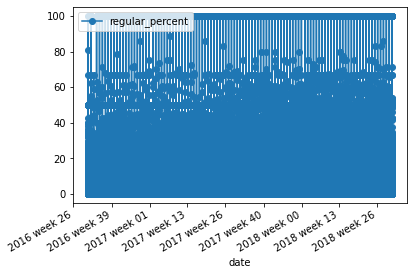

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Determine the date
df_week2_gb['date'] = pd.to_datetime(df_week2_gb.assign(day=1, month=1)[['year', 'month', 'day']])+pd.to_timedelta(df_week2_gb.week_number*7, unit='days')

# Plot
fig, ax = plt.subplots()
df_week2_gb.plot(x='date', y='regular_percent', marker='o', ax=ax)

# Format the x-ticks
myFmt = mdates.DateFormatter('%Y week %U')
ax.xaxis.set_major_formatter(myFmt)

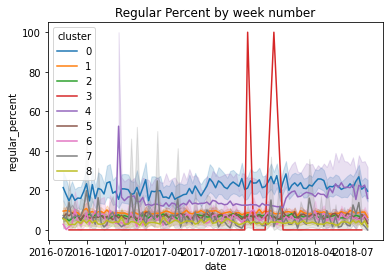

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns 

df_week2_gb['cluster'] = df_week2_gb['cluster'].astype('category')
sns.lineplot(x='date', y='regular_percent', hue='cluster',data=df_week2_gb)
plt.title('Regular Percent by week number')
plt.show()

# result 불러오기

In [22]:
result = pd.read_csv('cluster.csv', index_col=0)

In [23]:
result.head(1)

,store_id,n_card,count,total_amount,count/n_card,total_amount/n_card,weekdays_avg,weekend_avg,weekdays_amount_avg,weekend_amount_avg,regular_percent,p01_05,p06_10,p11_14,p15_17,p18_20,p21_24,total_amount/n_days,holiday_amount/n_holiday,cluster
0,0,12727,68773,5234611,5.403709,411.299678,9646.4,10270.5,719032.8,819723.5,26.890745,8.708359,11.026129,13.668155,17.008128,25.544909,24.04432,8857.209814,9962.354839,4


In [24]:
result['cluster'] = result['cluster'].astype('category')

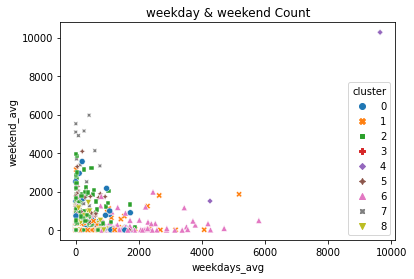

In [26]:
sns.scatterplot(x='weekdays_avg', y='weekend_avg', hue='cluster',style='cluster',data=result)
plt.title('weekday & weekend Count')
plt.show()

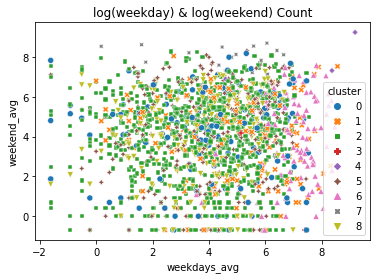

In [27]:
sns.scatterplot(x=np.log(result['weekdays_avg']), y=np.log(result['weekend_avg']), hue='cluster',style='cluster',data=result)
plt.title('log(weekday) & log(weekend) Count')
plt.show()

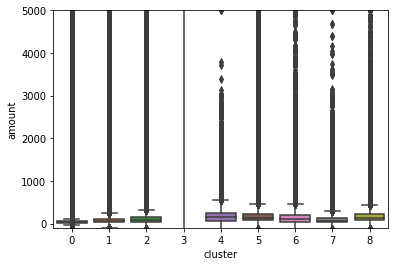

In [28]:
sns.boxplot(x="cluster", y="amount",  data=train)
plt.ylim(-100, 5000)
plt.show()

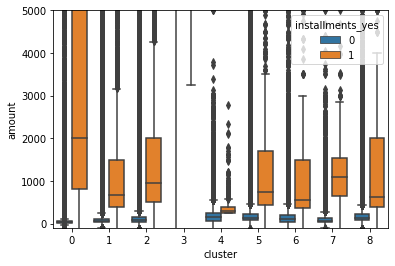

In [25]:
train['installments_yes'] = 0
train['installments_yes'][train['installments']>=1] = 1


sns.boxplot(x="cluster", y="amount", hue="installments_yes", data=train)
plt.ylim(-100, 5000)
plt.show()

In [30]:
pd.set_option('display.float_format', lambda x: '%.4f' % x)
pd.DataFrame(result.groupby(['cluster'])['p01_05', 'p06_10', 'p11_14', 'p15_17', 'p18_20', 'p21_24'].mean())

,p01_05,p06_10,p11_14,p15_17,p18_20,p21_24
cluster,,,,,,
0,2.2655,22.9753,36.5959,22.0387,10.8008,5.3237
1,1.4217,7.3352,34.9567,20.2105,26.0919,9.9840
2,0.1547,3.2611,35.4667,29.5190,26.1251,5.4734
3,0.0000,29.6610,60.7345,9.0395,0.5650,0.0000
4,4.6595,24.7373,21.9992,19.0745,18.0832,11.4462
5,23.5660,0.8073,1.9292,2.7248,15.0000,55.9727
6,2.6438,2.7046,23.2094,17.0919,30.4921,23.8582
7,0.6617,4.7015,37.5064,18.9713,25.8786,12.2806
8,1.5054,0.2951,9.0724,8.7843,46.7880,33.5547


In [31]:
pd.DataFrame(result.groupby(['cluster'])['n_card',  'count/n_card',
       'weekdays_amount_avg', 'weekend_amount_avg', 'regular_percent','total_amount/n_days', 'holiday_amount/n_holiday'].mean())

,n_card,count/n_card,weekdays_amount_avg,weekend_amount_avg,regular_percent,total_amount/n_days,holiday_amount/n_holiday
cluster,,,,,,,
0,568.3768,3.2263,29408.7507,37272.8442,22.7013,2619.5240,288.5789
1,4698.7758,1.9992,54025.0691,32734.3606,8.7868,2249.3934,2441.3525
2,520.6730,1.8071,25616.2137,31648.5142,6.9792,904.0494,506.5613
3,3.6667,3.4583,50649.6667,1417.0000,1.4815,43652.2436,0.0000
4,11675.0000,3.6766,397984.4500,252383.3750,18.1392,16613.4262,13977.8920
5,850.8450,1.5238,29254.8900,44570.3063,7.4632,974.6480,876.1571
6,608.7778,1.5793,200865.8343,23092.3081,5.9588,894.9167,565.7791
7,729.7059,1.4317,42153.3647,548832.6765,7.8336,992.5192,590.9426
8,661.2094,1.4067,23396.7171,32485.2970,3.7542,738.1236,620.6259


In [32]:
train.columns

Index(['store_id', 'date', 'time', 'card_id', 'amount', 'installments',
       'days_of_week', 'holyday', 'timestamp', 'year', 'month', 'day', 'hour',
       'min', 'sec', 'season', 'timezone', 'cluster', 'week_number',
       'installments_yes'],
      dtype='object')

In [49]:
pd.set_option('display.max_rows', None)
train.groupby(['cluster','days_of_week'])['amount','installments_yes','installments','month','season'].mean()


amount  installments_yes  installments   month  \
cluster days_of_week                                                      
0       0               89.6223            0.0029        0.0108  6.3190   
        1               98.6949            0.0030        0.0117  6.3265   
        2              102.9251            0.0038        0.0155  6.3324   
        3              100.6764            0.0034        0.0126  6.3351   
        4               81.2001            0.0031        0.0127  6.4094   
        5               52.4860            0.0023        0.0076  6.3383   
        6               45.7654            0.0004        0.0011  6.3298   
1       0              105.9131            0.0032        0.0105  6.3174   
        1              109.0698            0.0033        0.0109  6.3125   
        2              110.7038            0.0032        0.0104  6.3300   
        3              111.8422            0.0029        0.0096  6.3845   
        4              116.2583            0.0032        0.0103  6.4777   
        5              117.3697            0.0038        0.0120  6.4789   
        6              111.3429            0.0034        0.0105  6.4646   
2       0              180.7317            0.0121        0.0460  6.2989   
        1              179.1839            0.0118        0.0428  6.2823   
        2              175.8086            0.0107        0.0387  6.2676   
        3              176.2199            0.0114        0.0426  6.3713   
        4              174.9366            0.0113        0.0421  6.4426   
        5              166.1690            0.0108        0.0381  6.4363   
        6              142.4814            0.0072        0.0235  6.4095   
3       0            18814.7059            0.5882        2.7647  6.7059   
        1            26795.0000            0.5000        2.3000  7.3000   
        2            23703.5714            0.5000        2.2857  5.5714   
        3            21325.0000            0.6667        3.8333  6.5833   
        4            23671.4286            0.7143        3.0000  6.5714   
        5            43000.0000            0.5000        1.5000 11.5000   
        6            45000.0000            0.0000        0.0000  3.0000   
4       0              164.4670            0.0039        0.0112  5.5417   
        1              163.4136            0.0049        0.0133  5.5360   
        2              162.7392            0.0051        0.0146  5.5308   
        3              165.1147            0.0049        0.0195  5.5831   
        4              164.3997            0.0050        0.0142  5.6548   
        5              160.8703            0.0047        0.0125  5.7177   
        6              148.8765            0.0047        0.0132  5.7241   
5       0              220.2784            0.0027        0.0089  6.3271   
        1              244.8837            0.0037        0.0149  6.3221   
        2              246.0397            0.0029        0.0100  6.2853   
        3              249.6410            0.0027        0.0091  6.3902   
        4              237.8562            0.0030        0.0101  6.4767   
        5              224.6282            0.0029        0.0099  6.4656   
        6              202.6029            0.0029        0.0095  6.4431   
6       0              175.2421            0.0039        0.0137  5.8669   
        1              181.1855            0.0033        0.0124  5.9813   
        2              183.2329            0.0031        0.0097  6.0492   
        3              182.5817            0.0040        0.0169  6.1163   
        4              187.1352            0.0033        0.0104  6.1638   
        5              186.2134            0.0038        0.0124  6.1999   
        6              168.5908            0.0030        0.0092  6.3468   
7       0              137.1644            0.0131        0.0417  6.3861   
        1              147.9482            0.0164        0.0543  6.3583   
        2              159.2263            0.0158 

In [53]:
pd.pivot_table(train, index = ['cluster'], values = ['amount'], columns = 'days_of_week', aggfunc = 'mean',fill_value=0)

amount                                              \
days_of_week          0          1          2          3          4   
cluster                                                               
0               89.6223    98.6949   102.9251   100.6764    81.2001   
1              105.9131   109.0698   110.7038   111.8422   116.2583   
2              180.7317   179.1839   175.8086   176.2199   174.9366   
3            18814.7059 26795.0000 23703.5714 21325.0000 23671.4286   
4              164.4670   163.4136   162.7392   165.1147   164.3997   
5              220.2784   244.8837   246.0397   249.6410   237.8562   
6              175.2421   181.1855   183.2329   182.5817   187.1352   
7              137.1644   147.9482   159.2263   145.0640   149.7071   
8              208.3905   211.6559   210.7999   214.7070   214.9784   

                                    
days_of_week          5          6  
cluster                             
0               52.4860    45.7654  
1              117.3697   111.3429  
2              166.1690   142.4814  
3            43000.0000 45000.0000  
4              160.8703   148.8765  
5              224.6282   202.6029  
6              186.2134   168.5908  
7              287.5081   338.9168  
8              204.7729   179.0666

In [52]:
pd.pivot_table(train, index = ['cluster'], values = ['timestamp'], columns = 'days_of_week', aggfunc = 'count',fill_value=0)

timestamp                                                
days_of_week         0       1       2       3       4       5       6
cluster                                                               
0                38508   39132   38232   38324   40381   37015   33337
1               202544  211461  212918  212443  226388  238738  215451
2                98024  102946  103331  104314  109700  114435   96690
3                   17      10      14      12       7       2       1
4                23994   24282   24528   24277   24976   24814   21725
5                39563   43211   44537   45257   54193   63193   50263
6                12983   14792   14710   15309   16510   14627   11247
7                 3673    4091    3929    4080    3929    1486     938
8                25541   27351   29374   28804   34947   38783   32504

In [48]:
#mode
train.groupby(['cluster'])['amount','installments_yes','installments','month','days_of_week','season'].agg(lambda x:x.value_counts().index[0])

,amount,installments_yes,installments,month,days_of_week,season
cluster,,,,,,
0,15,0,0.0000,7,4,1
1,22,0,0.0000,5,5,0
2,30,0,0.0000,7,5,0
3,45000,1,0.0000,12,0,3
4,250,0,0.0000,3,4,0
5,85,0,0.0000,6,5,0
6,15,0,0.0000,5,4,0
7,35,0,0.0000,4,1,0
8,85,0,0.0000,7,5,0


In [70]:
days_time = pd.DataFrame(train.groupby(['cluster','hour'])['timestamp'].count())
days_time = days_time.unstack().fillna(0)
days_time

timestamp                                                             \
hour           0        1        2       3       4       5       6        7    
cluster                                                                        
0          6318.0   4945.0   3954.0  2991.0  2187.0  1924.0  2549.0   4811.0   
1         15461.0  10822.0   7309.0  5199.0  3691.0  3782.0  5697.0  12537.0   
2          1991.0    997.0    420.0   203.0   128.0    98.0   280.0    469.0   
3             0.0      0.0      0.0     0.0     0.0     0.0     3.0      0.0   
4          2632.0   2168.0   1634.0  1523.0  1361.0  2497.0  4855.0   5946.0   
5         35708.0  25284.0  16379.0  9204.0  4330.0  1673.0   678.0    299.0   
6          2075.0   1120.0    638.0   342.0   170.0   102.0   105.0     95.0   
7           276.0    121.0     33.0     5.0     1.0     0.0     1.0      0.0   
8          6070.0   2512.0    646.0   182.0    56.0    18.0    12.0     12.0   

                                                                           \
hour          8        9        10       11        12        13        14   
cluster                                                                     
0         7803.0  10182.0  11855.0  13854.0   29658.0   22963.0   17636.0   
1        26787.0  41522.0  48689.0  73277.0  181796.0  146589.0  106347.0   
2         1140.0   4085.0  10938.0  31292.0  108530.0   86313.0   58638.0   
3            4.0     10.0      7.0      4.0       6.0       8.0       4.0   
4         8119.0   8913.0   8695.0   8294.0    8244.0    8711.0    8829.0   
5          241.0    239.0    259.0    490.0    2235.0    2523.0    2677.0   
6          197.0    451.0    945.0   2981.0   11363.0    9108.0    5201.0   
7           16.0    137.0    405.0   1725.0    6223.0    3951.0    1598.0   
8           16.0     49.0    191.0    931.0    5358.0    6040.0    4809.0   

                                                                           \
hour          15       16       17        18        19        20       21   
cluster                                                                     
0        17024.0  17106.0  16083.0   16127.0   14566.0   12393.0  10964.0   
1        91173.0  88746.0  99382.0  127278.0  141831.0  123347.0  81553.0   
2        50499.0  49599.0  56840.0   73058.0   78709.0   61443.0  34045.0   
3            9.0      4.0      3.0       0.0       0.0       1.0      0.0   
4         9355.0  10347.0  11865.0   12236.0   11400.0    9773.0   9647.0   
5         2973.0   4053.0   7196.0   14305.0   25510.0   38187.0  47616.0   
6         3722.0   3739.0   5695.0    9274.0   11878.0   11894.0   8757.0   
7          771.0    772.0   1027.0    1361.0    1288.0     903.0    634.0   
8         4482.0   5425.0   9927.0   21707.0   35445.0   40819.0  34187.0   

                           
hour          22       23  
cluster                    
0         9225.0   7811.0  
1        49920.0  27208.0  
2        14497.0   5228.0  
3            0.0      0.0  
4         7262.0   4290.0  
5        51051.0  47107.0  
6         6337.0   3989.0  
7          485.0    393.0  
8        24013.0  14397.0

In [86]:
days_time.columns.set_levels(['hour'],level=0,inplace=True)

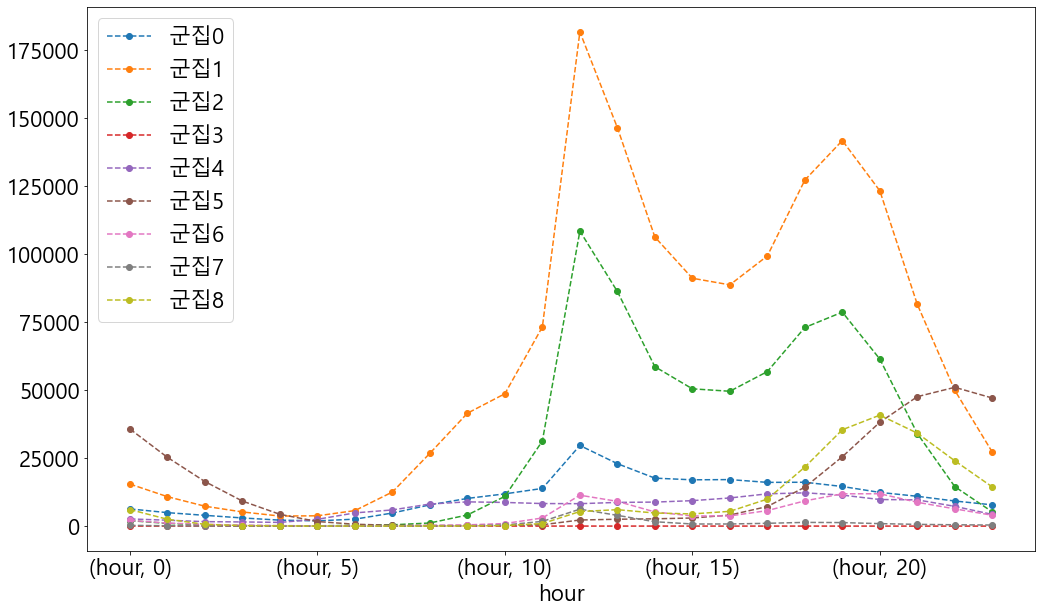

In [88]:
from matplotlib import rc
from matplotlib import rcParams
plt.rc('font',family='Malgun Gothic')
rcParams.update({'font.size': 22})
plt.rc('axes',unicode_minus=False)


fig,ax = plt.subplots(figsize=(17,10))
days_time.loc[0, :].plot(label = '군집0',ls="--",marker="o")
days_time.loc[1, :].plot(label = '군집1',ls="--",marker="o")
days_time.loc[2, :].plot(label = '군집2',ls="--",marker="o")
days_time.loc[3, :].plot(label = '군집3',ls="--",marker="o")
days_time.loc[4, :].plot(label = '군집4',ls="--",marker="o")
days_time.loc[5, :].plot(label = '군집5',ls="--",marker="o")
days_time.loc[6, :].plot(label = '군집6',ls="--",marker="o")
days_time.loc[7, :].plot(label = '군집7',ls="--",marker="o")
days_time.loc[8, :].plot(label = '군집8',ls="--",marker="o")

plt.xlabel('hour')
#ax.xaxis.set_ticklabels('l')
#plt.xticks([range(10,24)])
#plt.xticks(data3.columns)
plt.legend()
plt.show()

In [31]:
def days(days_of_week) :
    if (days_of_week == 0):
        return '월'
    elif (days_of_week == 1):
        return '화'
    elif (days_of_week == 2):
        return '수'
    elif (days_of_week == 3):
        return '목'
    elif (days_of_week == 4):
        return '금'
    elif (days_of_week == 5):
        return '토'
    else :
        return '일'
train['days'] = train['days_of_week'].apply(lambda x : days(x))

In [64]:
train['tt'] = '군집'
train['cluster_num'] = train['tt']+''+train['cluster'].astype('string')

In [73]:
train.head()

,store_id,date,time,card_id,amount,installments,days_of_week,holyday,timestamp,year,month,day,hour,min,sec,season,timezone,cluster,week_number,installments_yes,days,tt,cluster_num
0,0,2016-12-14,18:05:31,d297bba73f,5,0.0,2,0,2016-12-14 18:05:31,2016,12,14,18,5,31,3,4,4,50,0,수,군집,군집4
1,0,2016-12-14,18:05:54,d297bba73f,-5,0.0,2,0,2016-12-14 18:05:54,2016,12,14,18,5,54,3,4,4,50,0,수,군집,군집4
2,0,2016-12-19,12:42:31,0880849c05,144,0.0,0,0,2016-12-19 12:42:31,2016,12,19,12,42,31,3,2,4,51,0,월,군집,군집4
3,0,2016-12-19,12:48:08,8b4f9e0e95,66,0.0,0,0,2016-12-19 12:48:08,2016,12,19,12,48,8,3,2,4,51,0,월,군집,군집4
4,0,2016-12-19,13:31:08,7ad237eed0,24,0.0,0,0,2016-12-19 13:31:08,2016,12,19,13,31,8,3,2,4,51,0,월,군집,군집4


In [ ]:
sns.lineplot(x='hour', 
             y='value',
             hue='Group', 
             palette=['b','r'],
             data=draw_df)

In [93]:
df_hour = train.groupby(['cluster','hour'])['timestamp'].count().reset_index()
df_hour.columns = ['cluster','hour','count']
df_hour.head()

,cluster,hour,count
0,0,0,6318
1,0,1,4945
2,0,2,3954
3,0,3,2991
4,0,4,2187


<AxesSubplot:xlabel='hour', ylabel='count'>

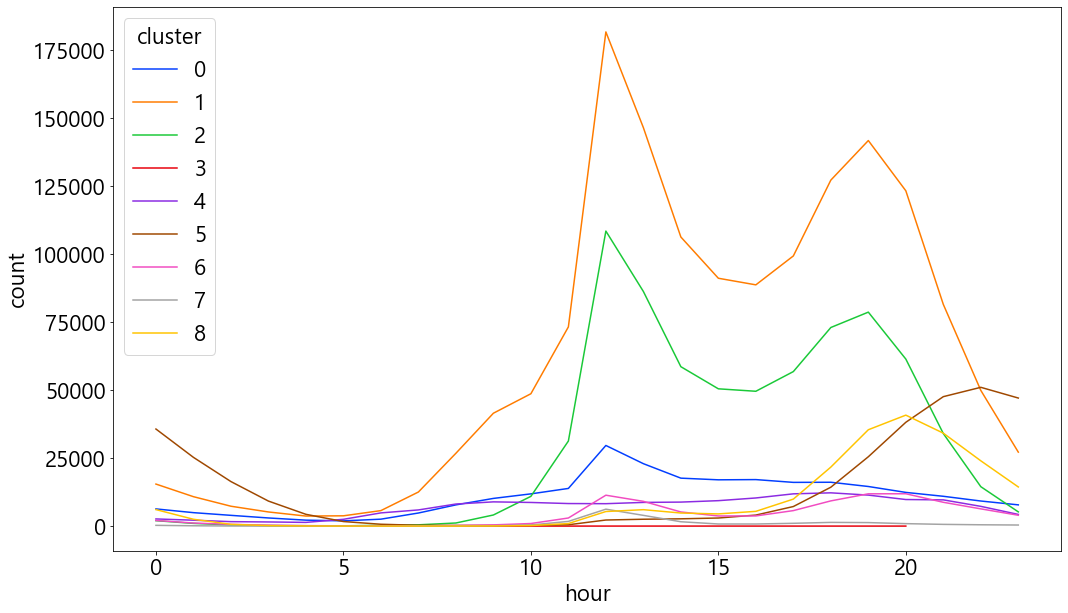

In [103]:
df_hour['cluster'] = df_hour['cluster'].astype('category')

fig,ax = plt.subplots(figsize=(17,10))
sns.set_palette("bright")
sns.lineplot(x='hour', 
             y='count',
             hue='cluster', 
             data=df_hour)